In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random

from tqdm import tqdm
import concurrent

### initial clustering

In [ ]:
path = 'drive/MyDrive/Copy of authors_tuples'

In [ ]:
''' load authors ''' # ~ 2 minutes
arxiv = []

with open(path, "r") as file:
    for line in file:
        arxiv.append(eval(line))

print(f'number of authors: {len(arxiv)}')

number of authors: 1766211


In [ ]:

''' clean up the number of authors (limit to 99th percentile of connections and a minimum of 10 connections) '''
connections = list()
for _author in arxiv:
connections.append(len(_author))

connections = np.array(connections)
perc_99 = np.percentile(connections, 99)
perc_05 = np.percentile(connections, 5)
min_n_connections = 10

print(f'min {min_n_connections}, perc 99 {perc_99}')

min 10, perc 99 50.0


In [ ]:
connections = np.array(connections)[connections<=perc_99]
connections = np.array(connections)[connections>=min_n_connections]

In [ ]:
arxiv2 = list()
for _author, _n_connections in zip(arxiv, connections):
    if _n_connections <= perc_99 and _n_connections >= min_n_connections:
        arxiv2.append(_author)

del arxiv

In [ ]:
''' initialize edge tuples'''
# and multigraph it

edge_tuples = []
for _author in arxiv2: #<<<< arxiv2
    for _e in _author:
        edge_tuples.append(_e)
        edge_tuples.append((_e[1],_e[0],_e[2]))

print(f'{len(edge_tuples)} edges (multigraph)')

5289044 edges (multigraph)


In [ ]:
print('n_authors:', len(arxiv2))

n_authors: 173091


In [ ]:
plt.hist(connections, bins=connections.max()-connections.min()+1)
plt.xlabel('n connections')
plt.ylabel('count')
plt.yscale('log');

# note, can flip through authors and remove any "collaboration"

In [ ]:
''' track changes '''
modularity_over_iterations = []

In [ ]:
''' calculate sum of weighted edges for full graph '''
m = 0
for _e in edge_tuples:
    m += _e[2]
m /= 2
print('sum of weighted edges:', m)

sum of weighted edges: 5483422.0


In [ ]:
''' initialize classes '''

class Node:
    def __init__(self,identifier,cluster_id,neighbours,weights):
        self.id = identifier
        self.cluster_id = cluster_id
        self.neighbours = []
        self.weights = []
    def __str__(self):  return self.id
    def __repr__(self): return self.id
    
class Cluster:
    def __init__(self,identifier):
        self.id = identifier
        self.nodes = []
    
    def __repr__(self): return self.id
    def __str__(self):  return self.id

In [ ]:
''' initialize nodes, create as list '''
# if we've never seen this node before, make node; add edge

nodes = dict()
character_accounted_for = []

all_characters = list()
for _e in edge_tuples:
    all_characters.append(_e)

np.random.seed(1234)
cluster_permutation = np.random.permutation(len(all_characters)) # random order of initial clusters


In [ ]:
''' create nodes '''
''' interestingly this is WAY faster as a try/except than as a if/else  (like 18 hours vs 2 minutes)'''

i = 0 # iterates over permutation
for row in tqdm(edge_tuples):
    # initialize character
    try:
        # add connection
        nodes[row[0]].neighbours.append(row[1])
        nodes[row[0]].weights.append(row[2])
    except:
        nodes[row[0]] = Node(identifier = row[0],
                          cluster_id = cluster_permutation[i], 
                          neighbours = [],
                          weights = [])
        i += 1
        nodes[row[0]].neighbours.append(row[1])
        nodes[row[0]].weights.append(row[2])


# remove nodes that have fewer than 10 connections
flagged_for_deletion = []
for _node in nodes.values():
    if len(_node.neighbours) <10:
        flagged_for_deletion.append(_node.id)

for flagged_node in flagged_for_deletion:
    del nodes[flagged_node]

# how do we remove neighbours from other nodes?
#for _node in nodes.values():
# just deal with it during summations


print('\n number of nodes:', len(nodes))

100%|██████████| 5289044/5289044 [00:17<00:00, 299887.60it/s]



 number of nodes: 104034


In [ ]:
''' set active sub round '''
n_subrounds = 10

for _node in nodes.values():
    _node.active = hash(_node.id)%n_subrounds

In [ ]:
''' put people into clusters '''
# due to singleton clustering at initialization, this is simply loops through

clusters = {}

for character in nodes.values():
    clusters[character.cluster_id] = Cluster(f'cluster_{character.cluster_id}') # < this caused so many problems
    clusters[character.cluster_id].nodes.append(character)

print('number of clusters:', len(clusters))

number of clusters: 104034


#### threading

In [ ]:

''' iterate over clusters '''
def get_bid(_cluster):
    _cid = int(_cluster.id.split('_')[1])

    # get active nodes (including active neighbours)
    _active_nodes = list()                    # initialize as set and intersect?
    for _node in _cluster.nodes:
        if _node.active == _subround: # node is in cluster
            _active_nodes.append(nodes[_node.id]) # < modified to point to node list
        for idx, _neighbour in enumerate(_node.neighbours): # neighbours
            try:
                if nodes[_neighbour].active == _subround:
                    _active_nodes.append(nodes[_neighbour])
            except:
                _node.neighbours.pop(idx)
                _node.weights.pop(idx)
    _active_nodes = list(set(_active_nodes)) # remove duplicates

    _bids = []
    #print('active:',len(_active_nodes))
    ''' iterate over active nodes '''
    for _active_node in _active_nodes:

        sum_in = 0 # sum of weights of links inside cluster
        k_i_in = 0 # weights from v to nodes of C
        sum_tot = 0 #weights of nodes to intra cluster
        k_i = 0 #weighted degree

        for _n in _cluster.nodes:
            for idx, (_neigh, _w) in enumerate(zip(_n.neighbours, _n.weights)):
                try:
                    if 'cluster_'+str(nodes[_neigh].cluster_id) == _cid:
                        sum_in += _w/2 # due to duplicates, may cause problems in contraction. during contraction; two self edges.
                    else: sum_tot += _w
                except:
                    _n.neighbours.pop(idx)
                    _n.weights.pop(idx)

        for idx, (_neigh, _w) in enumerate(zip(_active_node.neighbours, _active_node.weights)):
            try: 
                if nodes[_neigh].cluster_id == _cid:
                    k_i_in += _w
            except:
                pass
#              nodes[_neigh].neighbours.pop(idx)
#              nodes[_neigh].weights.pop(idx)
            k_i += _w


        modularity = (sum_in + k_i_in)/(2*m) - ((sum_tot + k_i)/(2*m))**2 - sum_in/(2*m) - (sum_tot/(2*m))**2 - (k_i/(2*m))**2

        _bids.append((_cid, _active_node.id, modularity))
    return _bids

In [ ]:
''' ... and repeat '''

iterations=1

for iteration in range(iterations):

    ''' cluster bids '''
    for _subround in range(n_subrounds): # subround
        ''' initialize bidding '''
        bids = dict()
        for _node in nodes.values():
            if _node.active == _subround:
                bids[_node.id] = []

        
        '''threading'''
        with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:

            futures = []
            with tqdm(total=len(clusters)) as pbar: # submitting jobs to threads
                for _cluster in clusters.values():
                    future = executor.submit(get_bid, _cluster)
                    futures.append(future)
                    pbar.update(1)

            results_bid_list = []
            with tqdm(total=len(futures)) as pbar: # collecting results (pretty quick)
                for future in concurrent.futures.as_completed(futures):
                    results_bid_list.append(future.result())
                    pbar.update(1)

#            results = [future.result() for future in concurrent.futures.as_completed(futures)]
        for _result_bid_list in results_bid_list: # each result is a list of bids now
            for _result in _result_bid_list:
                try:
                    # clusters without active nodes or neighbours will return "None", this filters them out.
                    bids[_result[1]].append((_result[0], _result[2]))
                except:
                    print(_result)
                    pass

        ''' update cluster via bids '''
  #        print(f' ---------------------- subround {_subround} bids -----------------------')
        failed_bids = 0
        for _node, _bid in bids.items(): # character_name as key, [(cID, mod, cut_cost, mod_cost), ... ] 

            ''' can thread this too, though less important '''
            _best_clust = []
            _best_val = -np.inf
            for _sub_bid in _bid: # can there be duplicate bids?
                # get best (or random)
                if _sub_bid[1] > _best_val:
                    _best_val = _sub_bid[1]
                    _best_clust = [_sub_bid[0]]
                elif _sub_bid[1] == _best_val:
                    _best_clust.append(_sub_bid[0])

            # choose best
            try: # sometimes active nodes don't have bids. this needs to be fixed (later). for now, just keep them in place.
                best_cluster_id = random.choice(_best_clust)
                previous_cluster_id = nodes[_node].cluster_id
                nodes[_node].cluster_id = best_cluster_id # update node cluster identity
                clusters[previous_cluster_id].nodes.remove(nodes[_node]) # add node to cluster
                clusters[best_cluster_id].nodes.append(nodes[_node]) # add node to cluster
            except:
                failed_bids+=1 # < from debugging
                print(_node, _bid)
                #print(f'problem with {_node}, no bids. remains in place')
        print(f'number of failed bids: {failed_bids}')

        ''' remove empty clusters '''
        flagged_clusters = []
        # identify empty clusters
        for _cid, _clust_values in clusters.items():
            if len(_clust_values.nodes) == 0:
                flagged_clusters.append(_cid)

        # remove empty clusters
        for cluster in flagged_clusters:
            del clusters[cluster]
            
    ''' calculate modularity of each cluster '''
    total_mod = 0

#    for _clust in clusters.values():
#        temp_mod = round(_clust.calc_nx_mod(),4)
#        total_mod += temp_mod
#    modularity_over_iterations.append(total_mod)

    print(f'iteration {iteration}. total modularity: {total_mod}. {len(clusters)} clusters')

100%|██████████| 104034/104034 [00:43<00:00, 2419.30it/s] 


number of failed bids: 0


100%|██████████| 95929/95929 [00:47<00:00, 2030.79it/s]


number of failed bids: 0


100%|██████████| 88378/88378 [00:44<00:00, 1965.23it/s]


number of failed bids: 0


100%|██████████| 81488/81488 [00:56<00:00, 1432.41it/s]


number of failed bids: 0


100%|██████████| 75056/75056 [00:59<00:00, 1262.45it/s]


number of failed bids: 0


100%|██████████| 69087/69087 [01:03<00:00, 1091.24it/s]


number of failed bids: 0


100%|██████████| 63468/63468 [01:00<00:00, 1043.42it/s]


number of failed bids: 0


100%|██████████| 58418/58418 [01:06<00:00, 875.12it/s] 


number of failed bids: 0


100%|██████████| 53520/53520 [00:52<00:00, 1021.46it/s]


number of failed bids: 0


100%|██████████| 49028/49028 [00:38<00:00, 1272.32it/s] 


number of failed bids: 0
iteration 0. total modularity: 0.0033000000000000004. 44860 clusters


number of clusters after 1 iteration (10 subrounds):44860


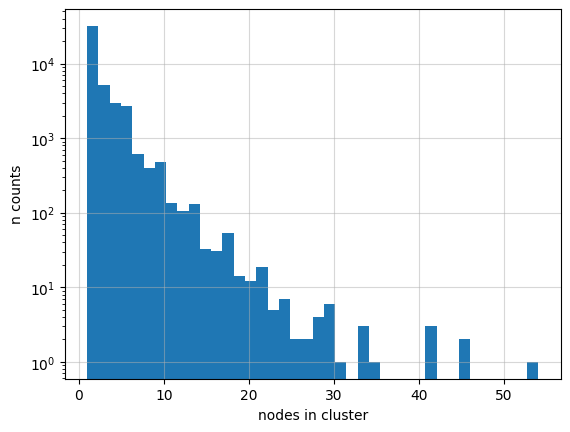

In [ ]:
''' check node cluster distribution '''

clust_node_dist = []
for _cluster in clusters.values():
    clust_node_dist.append(len(_cluster.nodes))

plt.hist(clust_node_dist,bins=40)
plt.yscale('log')
plt.xlabel('nodes in cluster')
plt.ylabel('n counts')
plt.grid(alpha=0.5)
print(f'number of clusters after 1 iteration ({n_subrounds} subrounds):{len(clusters)}')

In [ ]:
''' ... and repeat '''

iterations=1

for iteration in range(iterations):

    ''' cluster bids '''
    for _subround in range(n_subrounds): # subround
        ''' initialize bidding '''
        bids = dict()
        for _node in nodes.values():
            if _node.active == _subround:
                bids[_node.id] = []

        
        '''threading'''
        with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:

            futures = []
            with tqdm(total=len(clusters)) as pbar: # submitting jobs to threads
                for _cluster in clusters.values():
                    future = executor.submit(get_bid, _cluster)
                    futures.append(future)
                    pbar.update(1)

            results_bid_list = []
            with tqdm(total=len(futures)) as pbar: # collecting results (pretty quick)
                for future in concurrent.futures.as_completed(futures):
                    results_bid_list.append(future.result())
                    pbar.update(1)

#            results = [future.result() for future in concurrent.futures.as_completed(futures)]
        for _result_bid_list in results_bid_list: # each result is a list of bids now
            for _result in _result_bid_list:
                try:
                    # clusters without active nodes or neighbours will return "None", this filters them out.
                    bids[_result[1]].append((_result[0], _result[2]))
                except:
                    print(_result)
                    pass

        ''' update cluster via bids '''
  #        print(f' ---------------------- subround {_subround} bids -----------------------')
        failed_bids = 0
        for _node, _bid in bids.items(): # character_name as key, [(cID, mod, cut_cost, mod_cost), ... ] 

            ''' can thread this too, though less important '''
            _best_clust = []
            _best_val = -np.inf
            for _sub_bid in _bid: # can there be duplicate bids?
                # get best (or random)
                if _sub_bid[1] > _best_val:
                    _best_val = _sub_bid[1]
                    _best_clust = [_sub_bid[0]]
                elif _sub_bid[1] == _best_val:
                    _best_clust.append(_sub_bid[0])

            # choose best
            try: # sometimes active nodes don't have bids. this needs to be fixed (later). for now, just keep them in place.
                best_cluster_id = random.choice(_best_clust)
                previous_cluster_id = nodes[_node].cluster_id
                nodes[_node].cluster_id = best_cluster_id # update node cluster identity
                clusters[previous_cluster_id].nodes.remove(nodes[_node]) # add node to cluster
                clusters[best_cluster_id].nodes.append(nodes[_node]) # add node to cluster
            except:
                failed_bids+=1 # < from debugging
                print(_node, _bid)
                #print(f'problem with {_node}, no bids. remains in place')
        print(f'number of failed bids: {failed_bids}')

        ''' remove empty clusters '''
        flagged_clusters = []
        # identify empty clusters
        for _cid, _clust_values in clusters.items():
            if len(_clust_values.nodes) == 0:
                flagged_clusters.append(_cid)

        # remove empty clusters
        for cluster in flagged_clusters:
            del clusters[cluster]
            
    ''' calculate modularity of each cluster '''
    total_mod = 0

#    for _clust in clusters.values():
#        temp_mod = round(_clust.calc_nx_mod(),4)
#        total_mod += temp_mod
#    modularity_over_iterations.append(total_mod)

    print(f'iteration 2. total modularity: {total_mod}. {len(clusters)} clusters')

100%|██████████| 44860/44860 [00:59<00:00, 756.70it/s] 


number of failed bids: 0


100%|██████████| 42509/42509 [01:07<00:00, 626.45it/s] 


number of failed bids: 0


100%|██████████| 40362/40362 [01:10<00:00, 574.34it/s] 


number of failed bids: 0


100%|██████████| 38299/38299 [01:15<00:00, 504.41it/s] 


number of failed bids: 0


100%|██████████| 36412/36412 [01:17<00:00, 470.65it/s] 


number of failed bids: 0


100%|██████████| 34772/34772 [01:16<00:00, 453.08it/s] 


number of failed bids: 0


100%|██████████| 33117/33117 [01:18<00:00, 419.58it/s] 


number of failed bids: 0


100%|██████████| 31646/31646 [01:31<00:00, 346.65it/s] 


number of failed bids: 0


100%|██████████| 30182/30182 [01:34<00:00, 320.03it/s] 


number of failed bids: 0


100%|██████████| 28918/28918 [01:34<00:00, 304.46it/s] 


number of failed bids: 0
iteration 2. total modularity: 0.0027999999999999982. 27673 clusters


number of clusters after 2 iterations (10 subrounds):27673


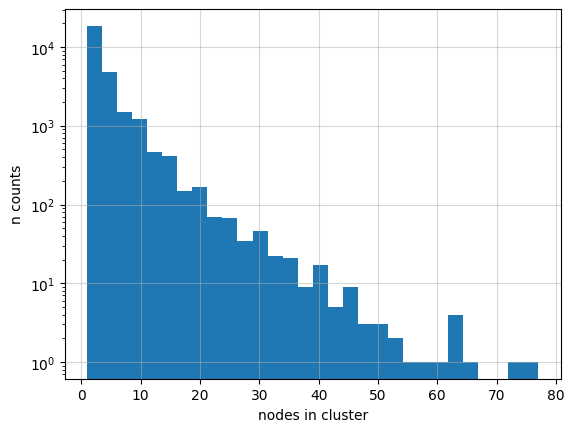

In [ ]:
''' check node cluster distribution '''

clust_node_dist = []
for _cluster in clusters.values():
    clust_node_dist.append(len(_cluster.nodes))

plt.hist(clust_node_dist,bins=30)
plt.yscale('log')
plt.xlabel('nodes in cluster')
plt.ylabel('n counts')
plt.grid(alpha=0.5)
print(f'number of clusters after 2 iterations ({n_subrounds} subrounds):{len(clusters)}')



In [ ]:
''' ... and repeat '''

iterations=1

for iteration in range(iterations):

    ''' cluster bids '''
    for _subround in range(n_subrounds): # subround
        ''' initialize bidding '''
        bids = dict()
        for _node in nodes.values():
            if _node.active == _subround:
                bids[_node.id] = []

        
        '''threading'''
        with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:

            futures = []
            with tqdm(total=len(clusters)) as pbar: # submitting jobs to threads
                for _cluster in clusters.values():
                    future = executor.submit(get_bid, _cluster)
                    futures.append(future)
                    pbar.update(1)

            results_bid_list = []
            with tqdm(total=len(futures)) as pbar: # collecting results (pretty quick)
                for future in concurrent.futures.as_completed(futures):
                    results_bid_list.append(future.result())
                    pbar.update(1)

#            results = [future.result() for future in concurrent.futures.as_completed(futures)]
        for _result_bid_list in results_bid_list: # each result is a list of bids now
            for _result in _result_bid_list:
                try:
                    # clusters without active nodes or neighbours will return "None", this filters them out.
                    bids[_result[1]].append((_result[0], _result[2]))
                except:
                    print(_result)
                    pass

        ''' update cluster via bids '''
  #        print(f' ---------------------- subround {_subround} bids -----------------------')
        failed_bids = 0
        for _node, _bid in bids.items(): # character_name as key, [(cID, mod, cut_cost, mod_cost), ... ] 

            ''' can thread this too, though less important '''
            _best_clust = []
            _best_val = -np.inf
            for _sub_bid in _bid: # can there be duplicate bids?
                # get best (or random)
                if _sub_bid[1] > _best_val:
                    _best_val = _sub_bid[1]
                    _best_clust = [_sub_bid[0]]
                elif _sub_bid[1] == _best_val:
                    _best_clust.append(_sub_bid[0])

            # choose best
            try: # sometimes active nodes don't have bids. this needs to be fixed (later). for now, just keep them in place.
                best_cluster_id = random.choice(_best_clust)
                previous_cluster_id = nodes[_node].cluster_id
                nodes[_node].cluster_id = best_cluster_id # update node cluster identity
                clusters[previous_cluster_id].nodes.remove(nodes[_node]) # add node to cluster
                clusters[best_cluster_id].nodes.append(nodes[_node]) # add node to cluster
            except:
                failed_bids+=1 # < from debugging
                print(_node, _bid)
                #print(f'problem with {_node}, no bids. remains in place')
        print(f'number of failed bids: {failed_bids}')

        ''' remove empty clusters '''
        flagged_clusters = []
        # identify empty clusters
        for _cid, _clust_values in clusters.items():
            if len(_clust_values.nodes) == 0:
                flagged_clusters.append(_cid)

        # remove empty clusters
        for cluster in flagged_clusters:
            del clusters[cluster]
            
    ''' calculate modularity of each cluster '''
    total_mod = 0

#    for _clust in clusters.values():
#        temp_mod = round(_clust.calc_nx_mod(),4)
#        total_mod += temp_mod
#    modularity_over_iterations.append(total_mod)

    print(f'iteration 3. total modularity: {total_mod}. {len(clusters)} clusters')

100%|██████████| 27673/27673 [01:38<00:00, 281.72it/s] 


number of failed bids: 0


100%|██████████| 26722/26722 [01:37<00:00, 273.90it/s] 


number of failed bids: 0


100%|██████████| 25718/25718 [01:03<00:00, 407.82it/s] 


number of failed bids: 0


100%|██████████| 24818/24818 [01:09<00:00, 356.56it/s] 


number of failed bids: 0


100%|██████████| 23964/23964 [01:14<00:00, 321.71it/s] 


number of failed bids: 0


100%|██████████| 23147/23147 [01:12<00:00, 320.29it/s] 


number of failed bids: 0


100%|██████████| 22422/22422 [01:15<00:00, 296.39it/s] 


number of failed bids: 0


100%|██████████| 21728/21728 [01:23<00:00, 258.84it/s] 


number of failed bids: 0


100%|██████████| 21064/21064 [01:23<00:00, 251.80it/s] 


number of failed bids: 0


100%|██████████| 20447/20447 [01:22<00:00, 246.67it/s] 


number of failed bids: 0
iteration 3. total modularity: 0.0034000000000000007. 19887 clusters


number of clusters after 3 iterations (10 subrounds): 19887


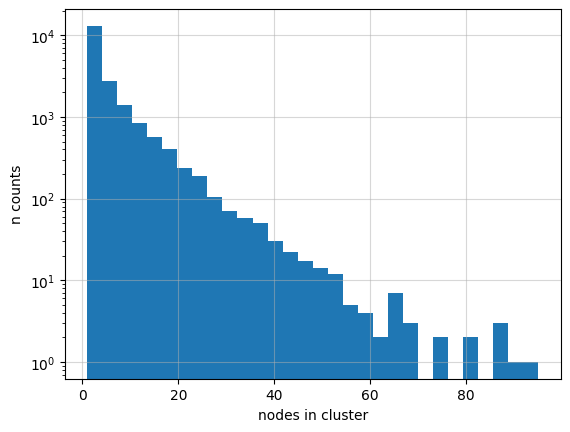

In [ ]:
''' check node cluster distribution '''

clust_node_dist = []
for _cluster in clusters.values():
    clust_node_dist.append(len(_cluster.nodes))

plt.hist(clust_node_dist,bins=30)
plt.yscale('log')
plt.xlabel('nodes in cluster')
plt.ylabel('n counts')
plt.grid(alpha=0.5)
print(f'number of clusters after 3 iterations ({n_subrounds} subrounds): {len(clusters)}')



In [ ]:

if False:
    safety_save = []
    for _node in nodes.values():
        safety_save.append(_node.cluster_id)

    safety_save[:10]
    #np.save('drive/MyDrive/safety_save_it3.npy',np.array(safety_save))

In [ ]:
''' ... and repeat '''

iterations=1

for iteration in range(iterations):

    ''' cluster bids '''
    for _subround in range(n_subrounds): # subround
        ''' initialize bidding '''
        bids = dict()
        for _node in nodes.values():
            if _node.active == _subround:
                bids[_node.id] = []

        
        '''threading'''
        with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:

            futures = []
            with tqdm(total=len(clusters)) as pbar: # submitting jobs to threads
                for _cluster in clusters.values():
                    future = executor.submit(get_bid, _cluster)
                    futures.append(future)
                    pbar.update(1)

            results_bid_list = []
            with tqdm(total=len(futures)) as pbar: # collecting results (pretty quick)
                for future in concurrent.futures.as_completed(futures):
                    results_bid_list.append(future.result())
                    pbar.update(1)

#            results = [future.result() for future in concurrent.futures.as_completed(futures)]
        for _result_bid_list in results_bid_list: # each result is a list of bids now
            for _result in _result_bid_list:
                try:
                    # clusters without active nodes or neighbours will return "None", this filters them out.
                    bids[_result[1]].append((_result[0], _result[2]))
                except:
                    print(_result)
                    pass

        ''' update cluster via bids '''
  #        print(f' ---------------------- subround {_subround} bids -----------------------')
        failed_bids = 0
        for _node, _bid in bids.items(): # character_name as key, [(cID, mod, cut_cost, mod_cost), ... ] 

            ''' can thread this too, though less important '''
            _best_clust = []
            _best_val = -np.inf
            for _sub_bid in _bid: # can there be duplicate bids?
                # get best (or random)
                if _sub_bid[1] > _best_val:
                    _best_val = _sub_bid[1]
                    _best_clust = [_sub_bid[0]]
                elif _sub_bid[1] == _best_val:
                    _best_clust.append(_sub_bid[0])

            # choose best
            try: # sometimes active nodes don't have bids. this needs to be fixed (later). for now, just keep them in place.
                best_cluster_id = random.choice(_best_clust)
                previous_cluster_id = nodes[_node].cluster_id
                nodes[_node].cluster_id = best_cluster_id # update node cluster identity
                clusters[previous_cluster_id].nodes.remove(nodes[_node]) # add node to cluster
                clusters[best_cluster_id].nodes.append(nodes[_node]) # add node to cluster
            except:
                failed_bids+=1 # < from debugging
                print(_node, _bid)
                #print(f'problem with {_node}, no bids. remains in place')
        print(f'number of failed bids: {failed_bids}')

        ''' remove empty clusters '''
        flagged_clusters = []
        # identify empty clusters
        for _cid, _clust_values in clusters.items():
            if len(_clust_values.nodes) == 0:
                flagged_clusters.append(_cid)

        # remove empty clusters
        for cluster in flagged_clusters:
            del clusters[cluster]
            
    ''' calculate modularity of each cluster '''
    total_mod = 0

#    for _clust in clusters.values():
#        temp_mod = round(_clust.calc_nx_mod(),4)
#        total_mod += temp_mod
#    modularity_over_iterations.append(total_mod)

    print(f'iteration 4. total modularity: {total_mod}. {len(clusters)} clusters')

100%|██████████| 19887/19887 [01:16<00:00, 258.28it/s] 


number of failed bids: 0


100%|██████████| 19383/19383 [01:30<00:00, 213.46it/s] 


number of failed bids: 0


100%|██████████| 18850/18850 [01:41<00:00, 185.22it/s] 


number of failed bids: 0


100%|██████████| 18359/18359 [01:31<00:00, 201.38it/s] 


number of failed bids: 0


100%|██████████| 17899/17899 [01:44<00:00, 170.66it/s] 


number of failed bids: 0


100%|██████████| 17443/17443 [01:33<00:00, 185.59it/s] 


number of failed bids: 0


100%|██████████| 17028/17028 [01:46<00:00, 159.19it/s] 


number of failed bids: 0


100%|██████████| 16623/16623 [02:12<00:00, 125.56it/s] 


number of failed bids: 0


100%|██████████| 16260/16260 [02:08<00:00, 126.31it/s] 


number of failed bids: 0


100%|██████████| 15890/15890 [02:18<00:00, 114.80it/s] 


number of failed bids: 0
iteration 4. total modularity: 0.005100000000000002. 15573 clusters


number of clusters after 4 iterations (10 subrounds): 15573


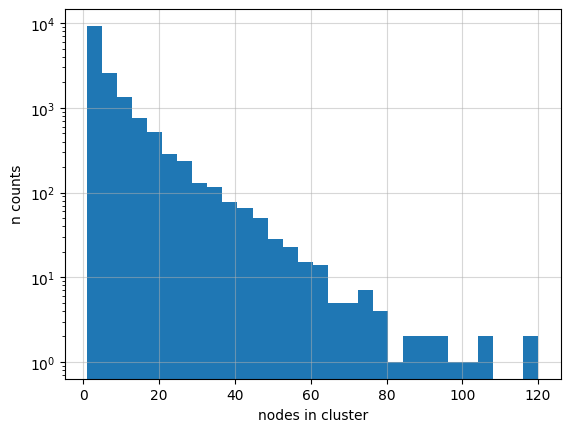

In [ ]:
''' check node cluster distribution '''

clust_node_dist = []
for _cluster in clusters.values():
    clust_node_dist.append(len(_cluster.nodes))

plt.hist(clust_node_dist,bins=30)
plt.yscale('log')
plt.xlabel('nodes in cluster')
plt.ylabel('n counts')
plt.grid(alpha=0.5)
print(f'number of clusters after 4 iterations ({n_subrounds} subrounds): {len(clusters)}')



In [ ]:

safety_save = []
for _node in nodes.values():
    safety_save.append(_node.cluster_id)

safety_save[:10]
np.save('drive/MyDrive/safety_save_it4_reduced.npy',np.array(safety_save))

#### compaction

In [ ]:
# quick reference for who is in this node
for _cluster in clusters.values():
    who = []
    for _node in _cluster.nodes:
        who.append(_node.id)
    _cluster.who = who
    
# self weights
# weights to neighbouring clusters

''' instead of looping over all clusters, loop over the subset of clusters that have edges ! '''

new_edge_tuples = []

for _cluster in tqdm(clusters.values()): # from 144k clusters, took ?? minutes
    running_connections = list()
    self_weight = 0
    for _node in _cluster.nodes:
        for _neigh, _w in zip(_node.neighbours, _node.weights):
            if _neigh in _cluster.who: self_weight += _w/2
            else: running_connections.append(nodes[_neigh].cluster_id)
    new_edge_tuples.append((_cluster.id, _cluster.id, self_weight))
    new_edge_tuples.append((_cluster.id, _cluster.id, self_weight)) # multigraph this
    
    running_connections = list(set(running_connections))

    # other edges
    for _connection in running_connections:
        _o_cluster = clusters[_connection]
        new_edge_weight = 0
        for _node in _o_cluster.nodes:
            for _neigh, _w in zip(_node.neighbours, _node.weights):
                if 'cluster_'+str(nodes[_neigh].cluster_id) == _cluster.id:
                    new_edge_weight += _w
        if new_edge_weight != 0:
            new_edge_tuples.append((_cluster.id, _o_cluster.id, new_edge_weight))
    
        

100%|██████████| 15573/15573 [19:51<00:00, 13.07it/s] 


In [ ]:
print('number of edges in compacted:',len(new_edge_tuples)) # 1 million edges

import json

json_object = json.dumps(new_edge_tuples)

with open("drive/MyDrive/compacted_arxiv.json", "w") as outfile:
    outfile.write(json_object)
    
#import json
#json.dumps(result)
#nodes[clusters[running_connections[1]].nodes[0].neighbours[0]].cluster_id

number of edges in compacted: 1122714


#### load safety save

In [ ]:
# load data, load cluster labels

author_cluster_labels = np.load('drive/MyDrive/safety_save_it4_reduced.npy')

''' load authors ''' # ~ 2 minutes
author_edge_data =  = []

path = 'drive/MyDrive/Copy of authors_tuples'
with open(path, "r") as file:
    for line in file:
        author_edge_data.append(eval(line))

#print(f'number of authors: {len(arxiv)}')





if True:
  ''' clean up the number of authors (limit to 99th percentile of connections and a minimum of 10 connections) '''
  connections = list()
    for _author in author_edge_data:
        connections.append(len(_author))

    connections = np.array(connections)
    perc_99 = np.percentile(connections, 99)
    perc_05 = np.percentile(connections, 5)
    min_n_connections = 10

    print(f'min {min_n_connections}, perc 99 {perc_99}')





connections = np.array(connections)[connections<=perc_99]
connections = np.array(connections)[connections>=min_n_connections]



if True:
    arxiv2 = list()
    for _author, _n_connections in zip(arxiv, connections):
        if _n_connections <= perc_99 and _n_connections >= min_n_connections:
            arxiv2.append(_author)

    del arxiv




''' initialize edge tuples'''
# and multigraph it

edge_tuples = []
for _author in arxiv2: #<<<< arxiv2
    for _e in _author:
        edge_tuples.append(_e)
        edge_tuples.append((_e[1],_e[0],_e[2]))

print(f'{len(edge_tuples)} edges (multigraph)')

print('n_authors:', len(arxiv2)) # expecting 173091


### compacted clustering

In [ ]:
''' load compacted arxiv connections '''
comp_arxiv = []

path = 'drive/MyDrive/compacted_arxiv.json'
with open(path, "r") as file:
    for line in file: # ~40 seconds
        comp_arxiv.append(eval(line)) # they end up as lists instead of tuples, but whatever.

new_edge_tuples = comp_arxiv[0]
print(f'number of comp_connections: {len(new_edge_tuples)}')

number of comp_connections: 1122714


In [ ]:
new_edge_tuples[:15]

[['cluster_5083995', 'cluster_5083995', 20.0],
 ['cluster_5083995', 'cluster_5083995', 20.0],
 ['cluster_5083995', 'cluster_4195336', 4],
 ['cluster_5083995', 'cluster_135182', 1],
 ['cluster_5083995', 'cluster_4611600', 6],
 ['cluster_5083995', 'cluster_3536401', 4],
 ['cluster_5083995', 'cluster_4791312', 2],
 ['cluster_5083995', 'cluster_5232148', 1],
 ['cluster_5083995', 'cluster_1465877', 19],
 ['cluster_5083995', 'cluster_2245145', 14],
 ['cluster_5083995', 'cluster_5253675', 12],
 ['cluster_5083995', 'cluster_3647021', 10],
 ['cluster_5083995', 'cluster_4883000', 1],
 ['cluster_5083995', 'cluster_1596992', 9],
 ['cluster_5083995', 'cluster_3109441', 1]]

In [ ]:
''' initialize classes '''

class Node:
    def __init__(self,identifier,cluster_id,neighbours,weights):
        self.id = identifier
        self.cluster_id = cluster_id
        self.neighbours = []
        self.weights = []
    def __str__(self):  return self.id
    def __repr__(self): return self.id
    
class Cluster:
    def __init__(self,identifier):
        self.id = identifier
        self.nodes = []
        return lc/m - (kc/m)**2
    
    def __repr__(self): return self.id
    def __str__(self):  return self.id

In [ ]:
''' initialize nodes, create as list '''
# if we've never seen this node before, make node; add edge

comp_nodes = dict()
comp_character_accounted_for = []

comp_all_characters = list()
for _e in new_edge_tuples:
    comp_all_characters.append(_e)

np.random.seed(1234)
comp_cluster_permutation = np.arange(len(comp_all_characters)) # random order of initial clusters


In [ ]:
''' calculate sum of weighted edges for full graph '''
comp_m = 0
for _e in new_edge_tuples:
    comp_m += _e[2]
comp_m /= 2
print('sum of compressed weighted edges:', comp_m)

sum of compressed weighted edges: 2895569.0


In [ ]:
''' create nodes '''
''' interestingly this is WAY faster as a try/except than as a if/else  (like 18 hours vs 2 minutes)'''

i = 0 # iterates over permutation
for row in tqdm(new_edge_tuples):
    # initialize character
    try:
        # add connection
        comp_nodes[row[0]].neighbours.append(row[1])
        comp_nodes[row[0]].weights.append(row[2])
    except:
        comp_nodes[row[0]] = Node(identifier = row[0],
                          cluster_id = row[0],#[i], 
                          neighbours = [],
                          weights = [])
        i += 1
        comp_nodes[row[0]].neighbours.append(row[1])
        comp_nodes[row[0]].weights.append(row[2])


print('\n number of nodes:', len(comp_nodes))



100%|██████████| 1122714/1122714 [00:00<00:00, 1129135.66it/s]


 number of nodes: 15573


In [ ]:
''' set active sub round '''
n_subrounds = 10

for _node in comp_nodes.values():
    _node.active = hash(_node.id)%n_subrounds

In [ ]:
''' put people into clusters '''
# due to singleton clustering at initialization, this is simply loops through

comp_clusters = {}

for character in comp_nodes.values():
    comp_clusters[character.cluster_id] = Cluster(character.cluster_id) # < this caused so many problems
    comp_clusters[character.cluster_id].nodes.append(character)

print('number of clusters:', len(comp_clusters))

number of clusters: 15573


In [ ]:

''' iterate over clusters '''
def comp_get_bid(_cluster):
    _cid = _cluster.id

    # get active nodes (including active neighbours)
    _active_nodes = list()                    # initialize as set and intersect?
    for _node in _cluster.nodes:
        if _node.active == _subround: # node is in cluster
            _active_nodes.append(comp_nodes[_node.id]) # < modified to point to node list
        for idx, _neighbour in enumerate(_node.neighbours): # neighbours
            try:
                if comp_nodes[_neighbour].active == _subround:
                    _active_nodes.append(comp_nodes[_neighbour])
            except:
                print('shouldnt get here')
                _node.neighbours.pop(idx)
                _node.weights.pop(idx)
    _active_nodes = list(set(_active_nodes)) # remove duplicates

    _bids = []
    ''' iterate over active nodes '''
    for _active_node in _active_nodes:

        sum_in = 0 # sum of weights of links inside cluster
        k_i_in = 0 # weights from v to nodes of C
        sum_tot = 0 #weights of nodes to intra cluster
        k_i = 0 #weighted degree

        for _n in _cluster.nodes:
            for idx, (_neigh, _w) in enumerate(zip(_n.neighbours, _n.weights)):
                try:
                    if comp_nodes[_neigh].cluster_id == _cid:
                        sum_in += _w/2 # due to duplicates, may cause problems in contraction. during contraction; two self edges.
                    else: sum_tot += _w
                except:
                    _n.neighbours.pop(idx)
                    _n.weights.pop(idx)

        for idx, (_neigh, _w) in enumerate(zip(_active_node.neighbours, _active_node.weights)):
            try: 
                if comp_nodes[_neigh].cluster_id == _cid:
                    k_i_in += _w
            except:
                pass
#              nodes[_neigh].neighbours.pop(idx)
#              nodes[_neigh].weights.pop(idx)
            k_i += _w

        modularity = (sum_in + k_i_in)/(2*comp_m) - ((sum_tot + k_i)/(2*comp_m))**2 - sum_in/(2*comp_m) - (sum_tot/(2*comp_m))**2 - (k_i/(2*comp_m))**2

        _bids.append((_cid, _active_node.id, modularity))

    return _bids

In [ ]:
''' local moving on compacted graph '''

iterations=1

for iteration in range(iterations):

    ''' cluster bids '''
    for _subround in range(n_subrounds): # subround
        ''' initialize bidding '''
        bids = dict()
        for _node in comp_nodes.values():
            if _node.active == _subround:
                bids[_node.id] = []

        '''threading'''
        with concurrent.futures.ThreadPoolExecutor() as executor:

            futures = []
            with tqdm(total=len(comp_clusters)) as pbar: # submitting jobs to threads
                for _cluster in comp_clusters.values():
                    future = executor.submit(comp_get_bid, _cluster)
                    futures.append(future)
                    pbar.update(1)

            results_bid_list = []
            with tqdm(total=len(futures)) as pbar: # collecting results (pretty quick)
                for future in concurrent.futures.as_completed(futures):
                    results_bid_list.append(future.result())
                    pbar.update(1)

#            results = [future.result() for future in concurrent.futures.as_completed(futures)]
        for _result_bid_list in results_bid_list: # each result is a list of bids now
            for _result in _result_bid_list:
                try:
                    # clusters without active nodes or neighbours will return "None", this filters them out.
                    bids[_result[1]].append((_result[0], _result[2]))
                except:
                    print(_result)
                    pass

        ''' update cluster via bids '''
  #        print(f' ---------------------- subround {_subround} bids -----------------------')
        failed_bids = 0
        for _node, _bid in bids.items(): # character_name as key, [(cID, mod, cut_cost, mod_cost), ... ] 

            ''' can thread this too, though less important '''
            _best_clust = []
            _best_val = -np.inf
            for _sub_bid in _bid: # can there be duplicate bids?
                # get best (or random)
                if _sub_bid[1] > _best_val:
                    _best_val = _sub_bid[1]
                    _best_clust = [_sub_bid[0]]
                elif _sub_bid[1] == _best_val:
                    _best_clust.append(_sub_bid[0])

            # choose best
            DEBUG_step = 0
            try: # sometimes active nodes don't have bids. this needs to be fixed (later). for now, just keep them in place.
                best_cluster_id = random.choice(_best_clust)
                DEBUG_step = 2
                previous_cluster_id = 'cluster_'+comp_nodes[str(_node)].cluster_id.split('_')[-1]
                DEBUG_step = 3
                comp_nodes[_node].cluster_id = best_cluster_id # update node cluster identity
                DEBUG_step = 4
                comp_clusters[previous_cluster_id].nodes.remove(comp_nodes[_node]) # add node to cluster
                DEBUG_step = 5
                comp_clusters[best_cluster_id].nodes.append(comp_nodes[_node]) # add node to cluster
            except:
                failed_bids += 1
                z = input()
                print(_node, _bid, 'step:', DEBUG_step)
                #print(f'problem with {_node}, no bids. remains in place')
        print(f'number of failed bids: {failed_bids}')

        ''' remove empty clusters '''
        flagged_clusters = []
        # identify empty clusters
        for _cidf, _clust_values in comp_clusters.items():
            if len(_clust_values.nodes) == 0:
                flagged_clusters.append(_cidf)

        # remove empty clusters
        for _clusterf in flagged_clusters:
            del comp_clusters[_clusterf]
            

100%|██████████| 15573/15573 [00:15<00:00, 994.23it/s] 


number of failed bids: 0


100%|██████████| 14446/14446 [00:15<00:00, 912.01it/s] 


number of failed bids: 0


100%|██████████| 13462/13462 [00:20<00:00, 641.36it/s] 


number of failed bids: 0


100%|██████████| 12487/12487 [00:31<00:00, 397.42it/s] 


number of failed bids: 0


100%|██████████| 11604/11604 [00:34<00:00, 340.88it/s] 


number of failed bids: 0


100%|██████████| 10810/10810 [00:35<00:00, 304.38it/s] 


number of failed bids: 0


100%|██████████| 10043/10043 [00:30<00:00, 325.21it/s]


number of failed bids: 0


100%|██████████| 9304/9304 [00:35<00:00, 265.46it/s] 


number of failed bids: 0


100%|██████████| 8638/8638 [00:48<00:00, 178.64it/s] 


number of failed bids: 0


100%|██████████| 7913/7913 [01:02<00:00, 126.70it/s] 


number of failed bids: 0


NameError: ignored

cluster_85610
cluster_5239273
cluster_4341703
cluster_5003937
cluster_1452524
number of comp_clusters after 1 iteration (10 subrounds):7278


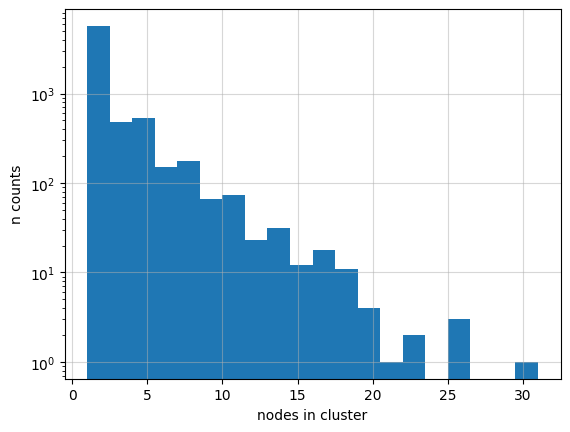

In [ ]:
''' check node cluster distribution '''

comp_clust_node_dist = []
c_max = 0
for idx, _cluster in comp_clusters.items():
    comp_clust_node_dist.append(len(_cluster.nodes))
    if len(_cluster.nodes) > c_max:
        c_max = len(_cluster.nodes)
        print(idx)

plt.hist(comp_clust_node_dist, bins=20)
plt.yscale('log')
plt.xlabel('nodes in cluster')
plt.ylabel('n counts')
plt.grid(alpha=0.5)
print(f'number of comp_clusters after 1 iteration ({n_subrounds} subrounds):{len(comp_clusters)}')

In [ ]:
''' can we plot the compacted starting point? '''

comp_graph = nx.graph(new_edge_tuples)

In [ ]:
test_edge_plottables = []

for _e in new_edge_tuples:
    test_edge_plottables.append((_e[0], _e[1]))

test_edge_plottables

[('cluster_5083995', 'cluster_5083995'),
 ('cluster_5083995', 'cluster_5083995'),
 ('cluster_5083995', 'cluster_4195336'),
 ('cluster_5083995', 'cluster_135182'),
 ('cluster_5083995', 'cluster_4611600'),
 ('cluster_5083995', 'cluster_3536401'),
 ('cluster_5083995', 'cluster_4791312'),
 ('cluster_5083995', 'cluster_5232148'),
 ('cluster_5083995', 'cluster_1465877'),
 ('cluster_5083995', 'cluster_2245145'),
 ('cluster_5083995', 'cluster_5253675'),
 ('cluster_5083995', 'cluster_3647021'),
 ('cluster_5083995', 'cluster_4883000'),
 ('cluster_5083995', 'cluster_1596992'),
 ('cluster_5083995', 'cluster_3109441'),
 ('cluster_5083995', 'cluster_3532355'),
 ('cluster_5083995', 'cluster_692806'),
 ('cluster_5083995', 'cluster_298573'),
 ('cluster_5083995', 'cluster_510030'),
 ('cluster_5083995', 'cluster_2193998'),
 ('cluster_5083995', 'cluster_3989599'),
 ('cluster_5083995', 'cluster_2175076'),
 ('cluster_5083995', 'cluster_5262438'),
 ('cluster_5083995', 'cluster_2351209'),
 ('cluster_5083995',

random 5000 compressed clusters


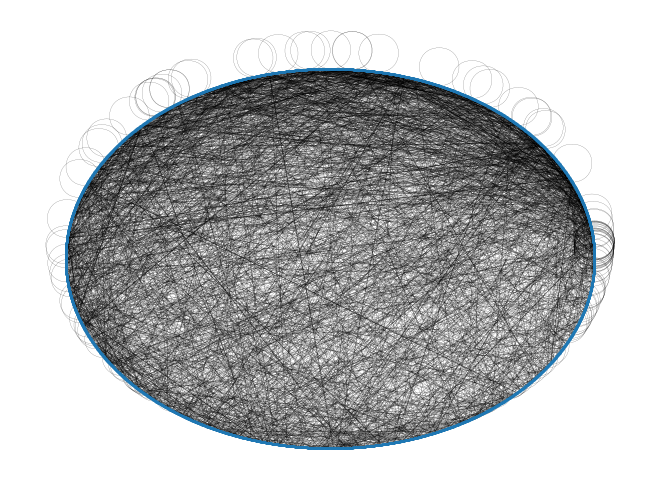

In [ ]:
mask = np.zeros(len(test_edge_plottables)).astype(bool)
mask[:5000] = True
np.random.shuffle(mask)

G = nx.from_edgelist(np.array(test_edge_plottables)[mask])
comp_circ_pos = nx.circular_layout(G)
nx.draw(G, pos = comp_circ_pos, width = 0.1, node_size=0.5)


print('random 5000 compressed clusters')

326
single cluster of compacted authors


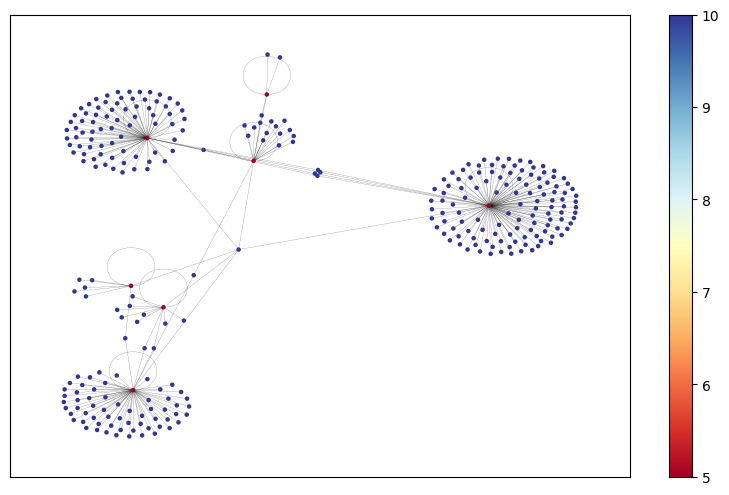

In [ ]:
''' plot a single cluster '''
# This cluster was selected because of its limited connectivity

target_cluster = 'cluster_71803' # cluster_85610?

single_cluster_edges = []
for _node in comp_clusters[target_cluster].nodes:
    for _neighbour in _node.neighbours:
        single_cluster_edges.append((_node.id,_neighbour))
print(len(single_cluster_edges))


# make nx graph
G = nx.from_edgelist(np.array(single_cluster_edges))



# define colours
single_node_colours = []
for _node in G.nodes:
    if comp_nodes[_node].cluster_id == target_cluster:
        single_node_colours.append(5) # These nodes are in the cluster
    else:
        single_node_colours.append(10) # These nodes are not



# plot it
comp_single_pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(10,6))
nx.draw_networkx_edges(G, pos=comp_single_pos, edgelist=None, width=0.1)

_plot_nodes = nx.draw_networkx_nodes(G, pos=comp_single_pos, nodelist=None, node_size=5, node_color=single_node_colours, cmap='RdYlBu')

plt.colorbar(_plot_nodes, ax=ax)


print('single cluster of compacted authors')

In [ ]:
''' how many neighbouring clusters? '''

target_cluster = 'cluster_71803'
n_neighbouring_clusters = []

for _node in comp_clusters[target_cluster].nodes:
    for _neighbour in _node.neighbours:
        n_neighbouring_clusters.append(comp_nodes[_neighbour].cluster_id)

n_neighbouring_clusters = set(n_neighbouring_clusters)
print(len(n_neighbouring_clusters))



263


In [ ]:
small_subgraph_edges = []

for _cluster_id in list(n_neighbouring_clusters):
    for _node in comp_clusters[_cluster_id].nodes:
        for _neigh in _node.neighbours:
            small_subgraph_edges.append((_node.id,_neigh))

len(small_subgraph_edges)

199813

In [ ]:
''' central cluster, and neighbouring clusters '''
# make nx graph
G_subgraph = nx.from_edgelist(small_subgraph_edges)


# define colours
subgraph_node_colours = []
for _node in G_subgraph.nodes:
    subgraph_node_colours.append(int(comp_nodes[_node].cluster_id.split('_')[1]))




# plot it
comp_subgraph_pos = nx.spring_layout(G_subgraph)
#nx.draw(G, pos = comp_single_pos, width = 0.1, node_size=5, node_color = single_node_colours, cmap='viridis')


fig, ax = plt.subplots(figsize=(20,12),dpi=300)
nx.draw_networkx_edges(G_subgraph, pos=comp_subgraph_pos, edgelist=None, width=0.1)

_plot_nodes = nx.draw_networkx_nodes(G_subgraph, pos=comp_subgraph_pos, nodelist=None, node_size=5, node_color=subgraph_node_colours, cmap='RdYlBu')

plt.colorbar(_plot_nodes, ax=ax)


print('subgraph cluster of compacted authors')

Output hidden; open in https://colab.research.google.com to view.